In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [3]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


gene_id    chr      start        end strand  \
gene_name                                                                 
0610005C13Rik  ENSMUSG00000109644.1   chr7   45567794   45575327      -   
0610006L08Rik  ENSMUSG00000108652.1   chr7   74818818   74853813      -   
0610009B22Rik  ENSMUSG00000007777.9  chr11   51685386   51688874      -   
0610009E02Rik  ENSMUSG00000086714.1   chr2   26445696   26459390      +   
0610009L18Rik  ENSMUSG00000043644.4  chr11  120348678  120351190      +   

                                   gene_type                 gid  
gene_name                                                         
0610005C13Rik                  antisense_RNA  ENSMUSG00000109644  
0610006L08Rik                        lincRNA  ENSMUSG00000108652  
0610009B22Rik                 protein_coding  ENSMUSG00000007777  
0610009E02Rik           processed_transcript  ENSMUSG00000086714  
0610009L18Rik  bidirectional_promoter_lncRNA  ENSMUSG00000043644

### MERFISH 

In [4]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/cell_labels.csv'
df = pd.read_csv(f, index_col=0)
print(df.shape)
f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_11mods_200219.tsv'
df_info = pd.read_csv(f, sep='\t', index_col=0)
df = df.join(df_info)
df = df.rename(columns={'label_v1': "final_label"})

print(df.shape)
df.head()


(243799, 8)
(243799, 15)


label     subclass  \
00002e16-356f-419f-b96e-ec7a9327033d      Sst_1          Sst   
000068a9-c788-4aa6-becc-175159da9f44       Endo  Endothelial   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde    L6_IT_1        L6_IT   
00008097-f502-40d1-a486-c61cdd999e7d  L2/3_IT_3      L2/3_IT   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb       VLMC         VLMC   

                                              sampleID            sliceID  \
00002e16-356f-419f-b96e-ec7a9327033d  dataset2_sample6  dataset2_slice109   
000068a9-c788-4aa6-becc-175159da9f44  dataset1_sample1   dataset1_slice50   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  dataset2_sample3  dataset2_slice139   
00008097-f502-40d1-a486-c61cdd999e7d  dataset2_sample1   dataset2_slice61   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  dataset1_sample5  dataset1_slice260   

                                     final_label  AP_distance (um)  \
00002e16-356f-419f-b96e-ec7a9327033d         I30              1180   
000068a9-c788-4aa6-becc-175159da9f44        Endo               490   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde          E8              1480   
00008097-f502-40d1-a486-c61cdd999e7d          E2               700   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb        VLMC              2590   

                                       pos_x (um)   pos_y (um)  \
00002e16-356f-419f-b96e-ec7a9327033d   -79.474594  2211.467867   
000068a9-c788-4aa6-becc-175159da9f44  3837.284502 -3847.753461   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  3502.243851 -3511.940334   
00008097-f502-40d1-a486-c61cdd999e7d -3975.718063 -2609.660891   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb -6370.114257   623.408623   

                                      cluster_joint_r0.1  cluster_joint_r0.2  \
00002e16-356f-419f-b96e-ec7a9327033d                 NaN                 NaN   
000068a9-c788-4aa6-becc-175159da9f44                 NaN                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde                 NaN                 NaN   
00008097-f502-40d1-a486-c61cdd999e7d                 NaN                 NaN   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb                 NaN                 NaN   

                                      cluster_joint_r0.4  cluster_joint_r0.8  \
00002e16-356f-419f-b96e-ec7a9327033d                 NaN                 NaN   
000068a9-c788-4aa6-becc-175159da9f44                 NaN                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde                 NaN                 NaN   
00008097-f502-40d1-a486-c61cdd999e7d                 NaN                 NaN   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb                 NaN                 NaN   

                                      tsne_x  tsne_y modality  
00002e16-356f-419f-b96e-ec7a9327033d     NaN     NaN      NaN  
000068a9-c788-4aa6-becc-175159da9f44     NaN     NaN      NaN  
0000691f-e1ef-43a9-90c4-82f1ea0c3fde     NaN     NaN      NaN  
00008097-f502-40d1-a486-c61cdd999e7d     NaN     NaN      NaN  
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb     NaN     NaN      NaN

In [5]:
print(df['sampleID'].unique())
print(df['sliceID'].unique())
print(df['subclass'].unique(), df['subclass'].unique().shape)
print(df['final_label'].unique(), df['final_label'].unique().shape)
df.describe()

['dataset2_sample6' 'dataset1_sample1' 'dataset2_sample3'
 'dataset2_sample1' 'dataset1_sample5' 'dataset1_sample6'
 'dataset1_sample2' 'dataset2_sample2' 'dataset1_sample4'
 'dataset2_sample4' 'dataset1_sample3' 'dataset2_sample5']
['dataset2_slice109' 'dataset1_slice50' 'dataset2_slice139'
 'dataset2_slice61' 'dataset1_slice260' 'dataset1_slice251'
 'dataset1_slice241' 'dataset1_slice313' 'dataset1_slice91'
 'dataset1_slice301' 'dataset2_slice10' 'dataset1_slice71'
 'dataset1_slice102' 'dataset2_slice189' 'dataset1_slice170'
 'dataset2_slice31' 'dataset2_slice79' 'dataset1_slice291'
 'dataset2_slice261' 'dataset1_slice212' 'dataset2_slice309'
 'dataset1_slice122' 'dataset1_slice283' 'dataset1_slice10'
 'dataset2_slice249' 'dataset1_slice200' 'dataset2_slice119'
 'dataset2_slice99' 'dataset2_slice40' 'dataset2_slice70'
 'dataset1_slice31' 'dataset1_slice232' 'dataset1_slice201'
 'dataset2_slice129' 'dataset2_slice319' 'dataset2_slice201'
 'dataset1_slice81' 'dataset2_slice90' 'dataset

AP_distance (um)     pos_x (um)     pos_y (um)  cluster_joint_r0.1  \
count     243799.000000  243799.000000  243799.000000         6759.000000   
mean        1716.749659    -373.633657    -440.671748            1.631750   
std          861.859219    4308.934501    2660.869182            0.644188   
min            0.000000  -10050.517800   -6088.078998            1.000000   
25%         1010.000000   -4468.442032   -2875.058474            1.000000   
50%         1690.000000     -17.799862    -436.148682            2.000000   
75%         2380.000000    3372.871195    1965.752883            2.000000   
max         3280.000000    8661.158694    5315.703233            3.000000   

       cluster_joint_r0.2  cluster_joint_r0.4  cluster_joint_r0.8  \
count         6759.000000         6759.000000         6759.000000   
mean             2.186122            3.161562            5.183755   
std              1.033893            1.855922            3.349517   
min              1.000000            1.000000            1.000000   
25%              1.000000            1.000000            2.000000   
50%              2.000000            3.000000            5.000000   
75%              3.000000            5.000000            8.000000   
max              4.000000            7.000000           14.000000   

            tsne_x       tsne_y  
count  6759.000000  6759.000000  
mean     -0.034609    -0.330806  
std       5.668253     3.467902  
min     -10.107104    -8.297587  
25%      -5.089192    -2.371828  
50%      -1.761943    -0.386314  
75%       5.787570     2.205278  
max       9.757397     7.035812

In [6]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/merfish_M1.h5ad'
data = h5py.File(f, 'r')
list(data.keys())

['X', 'obs', 'var']

In [24]:
X = data['X'][()]
print(X.shape)
var = data['var'][()]
var = np.array([a[0] for a in data['var'][()]])
print(var.shape)
obs = data['obs'][()]
obs = np.array([a[0] for a in data['obs'][()]])
print(obs.shape)
print(var)

(241628, 254)
(254,)
(241628,)
['1700022I11Rik' '1810046K07Rik' '5031425F14Rik' '5730522E02Rik' 'Acta2'
 'Adam2' 'Adamts2' 'Adamts4' 'Adra1b' 'Alk' 'Ankfn1' 'Ano4' 'Aqp4' 'Asic4'
 'B4galnt2' 'B4galnt3' 'Barx2' 'Bcl11b' 'Bdnf' 'Bgn' 'Blnk' 'Bmpr1b'
 'Brinp3' 'C1ql3' 'C1qtnf7' 'Cacng5' 'Calb2' 'Camk2d' 'Car3' 'Cbln2'
 'Cbln4' 'Ccbe1' 'Ccdc162' 'Ccdc3' 'Ccdc80' 'Ccnb1' 'Cd14' 'Cd24a' 'Cdca7'
 'Cdcp1' 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh9' 'Ceacam9' 'Cemip' 'Chat' 'Chn2'
 'Chodl' 'Chrm2' 'Chrna2' 'Cldn5' 'Clrn1' 'Cntnap5b' 'Cobll1' 'Col14a1'
 'Col15a1' 'Col23a1' 'Col24a1' 'Col25a1' 'Corin' 'Cplx3' 'Crhr2' 'Crispld2'
 'Cspg4' 'Ctss' 'Cux2' 'Cxcl14' 'Daam2' 'Dmkn' 'Dnase1l3' 'Dscaml1'
 'Egfem1' 'Egfr' 'Egln3' 'Egr2' 'Elfn1' 'Enpp6' 'Epha7' 'Fam19a2' 'Fam84b'
 'Fbxl7' 'Fezf2' 'Flrt3' 'Flt1' 'Fndc7' 'Fosb' 'Foxp2' 'Frem2' 'Fst' 'Gfap'
 'Glra1' 'Gpc6' 'Grik1' 'Grin3a' 'Grm1' 'Grm8' 'Hpse' 'Hs3st5' 'Igf2'
 'Igfbp4' 'Igfbp5' 'Ikzf2' 'Il1rapl2' 'Il4ra' 'Inpp4b' 'Iqgap2' 'Itgb8'
 'Kcng1' 'Kcnj8' 'L3mbtl4' 

In [27]:
assert np.all(obs==df.index.values)
# df = df.reindex(obs)

In [28]:
data_mfish = pd.DataFrame(X.T, 
                          index=df_genes_v2.reindex(var)['gid'].values, 
                          columns=obs)
print(data_mfish.shape)
data_mfish.head()

(254, 241628)


00002e16-356f-419f-b96e-ec7a9327033d  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    000068a9-c788-4aa6-becc-175159da9f44  \
ENSMUSG00000028451                              0.000000   
ENSMUSG00000036027                              0.000000   
ENSMUSG00000085129                              0.000000   
ENSMUSG00000032985                              0.000000   
ENSMUSG00000035783                              1.738648   

                    0000691f-e1ef-43a9-90c4-82f1ea0c3fde  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00008097-f502-40d1-a486-c61cdd999e7d  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00012933-4bb8-41e4-93d1-fadbff7b7da3  \
ENSMUSG00000028451                              0.000000   
ENSMUSG00000036027                              0.000000   
ENSMUSG00000085129                              0.000000   
ENSMUSG00000032985                              0.000000   
ENSMUSG00000035783                              1.071788   

                    0001439e-700a-4c9e-ba58-28e57fc1ddd0  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00014652-d295-4044-89b0-01db2fc72684  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    000194b4-e96d-431d-83e1-ea123e1ad6ba  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    0001b796-672e-45f1-b608-4e8da3bd140f  ...  \
ENSMUSG00000028451                              0.000000  ...   
ENSMUSG00000036027                              0.988327  ...   
ENSMUSG00000085129                              0.000000  ...   
ENSMUSG00000032985                              0.000000  ...   
ENSMUSG00000035783                              0.000000  ...   

                    fffe3119-4fe9-4d36-91c4-d2f121c925b6  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                   

In [29]:
data_mfish_2 = pd.DataFrame(X.T, 
                          index=var, 
                          columns=obs)
print(data_mfish_2.shape)
data_mfish_2.head()

(254, 241628)


00002e16-356f-419f-b96e-ec7a9327033d  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               000068a9-c788-4aa6-becc-175159da9f44  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.000000   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      1.738648   

               0000691f-e1ef-43a9-90c4-82f1ea0c3fde  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00008097-f502-40d1-a486-c61cdd999e7d  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00012933-4bb8-41e4-93d1-fadbff7b7da3  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.000000   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      1.071788   

               0001439e-700a-4c9e-ba58-28e57fc1ddd0  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00014652-d295-4044-89b0-01db2fc72684  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               000194b4-e96d-431d-83e1-ea123e1ad6ba  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               0001b796-672e-45f1-b608-4e8da3bd140f  ...  \
1700022I11Rik                              0.000000  ...   
1810046K07Rik                              0.988327  ...   
5031425F14Rik                              0.000000  ...   
5730522E02Rik                              0.000000  ...   
Acta2                                      0.000000  ...   

               fffe3119-4fe9-4d36-91c4-d2f121c925b6  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               fffe7413-84d5-431e-baac-13dc98a63a10  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.730213   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      0.000000   

             

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


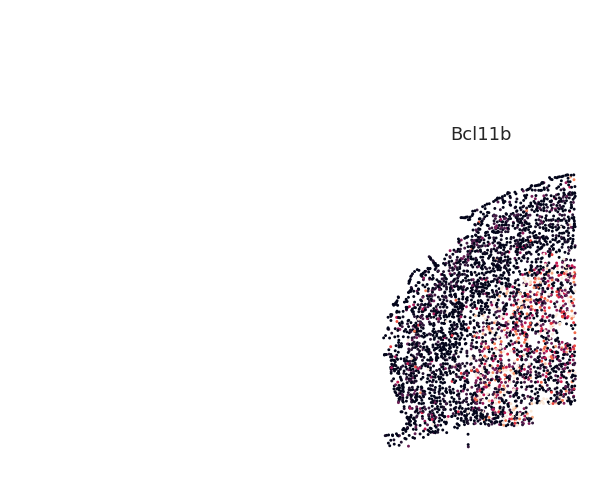

In [30]:
sample_n = 1000
gene = 'Bcl11b'
df_plot = df.join(data_mfish_2.loc[gene].to_frame(gene))

fig, ax = plt.subplots(figsize=(8,6))
tx, ty, tc = 'pos_x (um)', 'pos_y (um)', gene
snmcseq_utils.plot_tsne_values_ax(df_plot[df_plot['sliceID']=='dataset1_slice50'], ax, 
                    tx, ty, tc, 
#                     sample_n=sample_n,
#                     legend_mode=1,
                   )
ax.set_aspect('equal')
ax.grid('off')
plt.show()

In [7]:
def filter_l5pt(x):
    if x in ['E27', 'E33', 'E30', 'E36', 'E37', ]:
        return x
    else:
        return "nonPT"
    
def filter_l5pt2(x):
    if x == 'NA':
        return "nonPT" 
    else:
        return str(int(float(x)))
    
    
df_plot = df.copy()
df_plot['final_label'] = df['final_label'].apply(filter_l5pt)
df_plot['cluster_joint_r0.1'] = df['cluster_joint_r0.1'].fillna('NA').astype(str).apply(filter_l5pt2)
df_plot['cluster_joint_r0.4'] = df['cluster_joint_r0.4'].fillna('NA').astype(str).apply(filter_l5pt2)

In [8]:
print(len(df_plot['sliceID'].unique()))
df_plot.head()

64


label     subclass  \
00002e16-356f-419f-b96e-ec7a9327033d      Sst_1          Sst   
000068a9-c788-4aa6-becc-175159da9f44       Endo  Endothelial   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde    L6_IT_1        L6_IT   
00008097-f502-40d1-a486-c61cdd999e7d  L2/3_IT_3      L2/3_IT   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb       VLMC         VLMC   

                                              sampleID            sliceID  \
00002e16-356f-419f-b96e-ec7a9327033d  dataset2_sample6  dataset2_slice109   
000068a9-c788-4aa6-becc-175159da9f44  dataset1_sample1   dataset1_slice50   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  dataset2_sample3  dataset2_slice139   
00008097-f502-40d1-a486-c61cdd999e7d  dataset2_sample1   dataset2_slice61   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  dataset1_sample5  dataset1_slice260   

                                     final_label  AP_distance (um)  \
00002e16-356f-419f-b96e-ec7a9327033d       nonPT              1180   
000068a9-c788-4aa6-becc-175159da9f44       nonPT               490   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde       nonPT              1480   
00008097-f502-40d1-a486-c61cdd999e7d       nonPT               700   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb       nonPT              2590   

                                       pos_x (um)   pos_y (um)  \
00002e16-356f-419f-b96e-ec7a9327033d   -79.474594  2211.467867   
000068a9-c788-4aa6-becc-175159da9f44  3837.284502 -3847.753461   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  3502.243851 -3511.940334   
00008097-f502-40d1-a486-c61cdd999e7d -3975.718063 -2609.660891   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb -6370.114257   623.408623   

                                     cluster_joint_r0.1  cluster_joint_r0.2  \
00002e16-356f-419f-b96e-ec7a9327033d              nonPT                 NaN   
000068a9-c788-4aa6-becc-175159da9f44              nonPT                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde              nonPT                 NaN   
00008097-f502-40d1-a486-c61cdd999e7d              nonPT                 NaN   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb              nonPT                 NaN   

                                     cluster_joint_r0.4  cluster_joint_r0.8  \
00002e16-356f-419f-b96e-ec7a9327033d              nonPT                 NaN   
000068a9-c788-4aa6-becc-175159da9f44              nonPT                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde              nonPT                 NaN   
00008097-f502-40d1-a486-c61cdd999e7d              nonPT                 NaN   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb              nonPT                 NaN   

                                      tsne_x  tsne_y modality  
00002e16-356f-419f-b96e-ec7a9327033d     NaN     NaN      NaN  
000068a9-c788-4aa6-becc-175159da9f44     NaN     NaN      NaN  
0000691f-e1ef-43a9-90c4-82f1ea0c3fde     NaN     NaN      NaN  
00008097-f502-40d1-a486-c61cdd999e7d     NaN     NaN      NaN  
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb     NaN     NaN      NaN

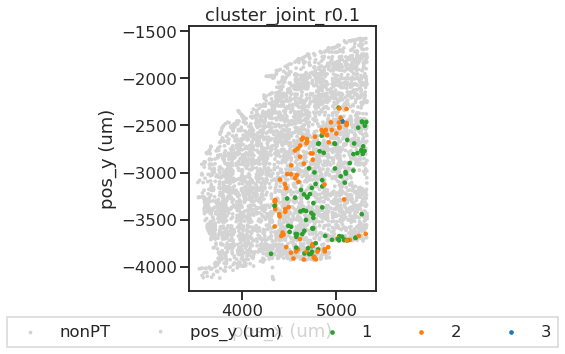

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8*1,6*1))
tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'cluster_joint_r0.1'
snmcseq_utils.plot_tsne_labels_ax(df_plot[((df_plot['sliceID']=='dataset1_slice50') & (df_plot['cluster_joint_r0.1']=='nonPT'))], ax, 
                    tx, ty, tc, 
                    kw_colors={"nonPT": 'lightgray', '1': 'C2', '2': 'C1', '3': "C0"},
                    legend_mode=1,
                    s=5,
                    t_xlim=None,
                    t_ylim=None,
                    rasterized=True,
                   )
snmcseq_utils.plot_tsne_labels_ax(df_plot[((df_plot['sliceID']=='dataset1_slice50') & (df_plot['cluster_joint_r0.1']!='nonPT'))], ax, 
                    tx, ty, tc, 
                    kw_colors={"nonPT": 'lightgray', '1': 'C2', '2': 'C1', '3': "C0"},
                    legend_mode=1,
                    s=10,
                    t_xlim=None,
                    t_ylim=None,
                    rasterized=True,
                   )
ax.set_aspect('equal')
ax.grid(False)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_l5pt.pdf'))
plt.show()

In [29]:
df_plot.loc[df_plot['sampleID']=='dataset1_sample1', 'sliceID'].unique()

array(['dataset1_slice50', 'dataset1_slice10', 'dataset1_slice31',
       'dataset1_slice21', 'dataset1_slice40', 'dataset1_slice1'], dtype=object)

In [31]:
df_plot.groupby(['sampleID', 'sliceID']).size().reset_index().groupby('sampleID').size()

sampleID
dataset1_sample1    6
dataset1_sample2    5
dataset1_sample3    4
dataset1_sample4    6
dataset1_sample5    6
dataset1_sample6    6
dataset2_sample1    4
dataset2_sample2    6
dataset2_sample3    6
dataset2_sample4    5
dataset2_sample5    5
dataset2_sample6    5
dtype: int64

In [35]:
def format_sliceID(x):
    a, b = x[:len('dataset1_slice')], x[len('dataset1_slice'):]
    y = a + b.zfill(3) 
    return y 
format_sliceID('dataset1_slice5')

'dataset1_slice005'

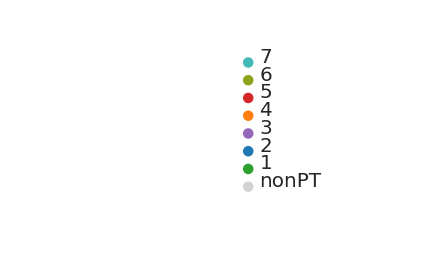

In [17]:
# kw_colors=collections.OrderedDict({
#                                     "nonPT": 'lightgray', 
#                                     '1': '#d75c5c',
#                                     '2': '#d7c55c',
#                                     '3': '#7fd75c',
#                                     '4': '#5cd7a2',
#                                     '5': '#5ca2d7',
#                                     '6': '#7f5cd7',
#                                     '7': '#d75cc5',
#                                   })

kw_colors=collections.OrderedDict({
                                    "nonPT": 'lightgray', 
                                    '1': 'C2',
                                    '2': 'C0',
                                    '3': 'C4',
                                    '4': 'C1',
                                    '5': 'C3',
                                    '6': '#8ca31b',
                                    '7': '#43bab6',
                                  })

joint_cluster = 'cluster_joint_r0.4'

scale=0.01
fig, ax = plt.subplots()
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')
snmcseq_utils.savefig(fig, figure_format.format('cluster_legend_7clst'))
plt.show()


In [11]:
# # sample
# # n = len(df_plot_sub['sliceID'].unique())

# samples = np.sort(df_plot['sampleID'].unique())
# nx = 6
# ny = len(samples) 

# fig, axss = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
# for axs, sample in zip(axss, samples):
#     df_plot_sub = df_plot[df_plot['sampleID']==sample].copy()
#     tx, ty, tc = 'pos_x (um)', 'pos_y (um)', joint_cluster
#     df_plot_sub['sliceID'] = df_plot_sub['sliceID'].apply(format_sliceID)
#     for i, (_slice, df_sub) in enumerate(df_plot_sub.groupby('sliceID')):
#         print('.', end='')
#         dis = df_sub.
#         ax = axs[i]
#         legend_mode = -1
#         legend_kws = {}
#         snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]=='nonPT')], ax, 
#                             tx, ty, tc, 
#                             kw_colors=kw_colors,
#                             legend_mode=-1,
#                             s=5,
#                             t_xlim=None,
#                             t_ylim=None,
#                             rasterized=True,
#                            )
#         snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]!='nonPT')], ax, 
#                             tx, ty, tc, 
#                             kw_colors=kw_colors,
#                             legend_mode=legend_mode,
#                             legend_kws=legend_kws,
#                             s=10,
#                             t_xlim=None,
#                             t_ylim=None,
#                             rasterized=True,
#                            )

#         ax.set_title(_slice)
#         ax.set_aspect('equal')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel('')
#         if i == 0:
#             ax.set_ylabel(sample)
#         else:
#             ax.set_ylabel('')
#         ax.grid(False)

#     for ax in axs[min(i+1, nx):]:
#         ax.axis('off')

# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
# snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_l5pt_7clst'))
# plt.show()

................................................................

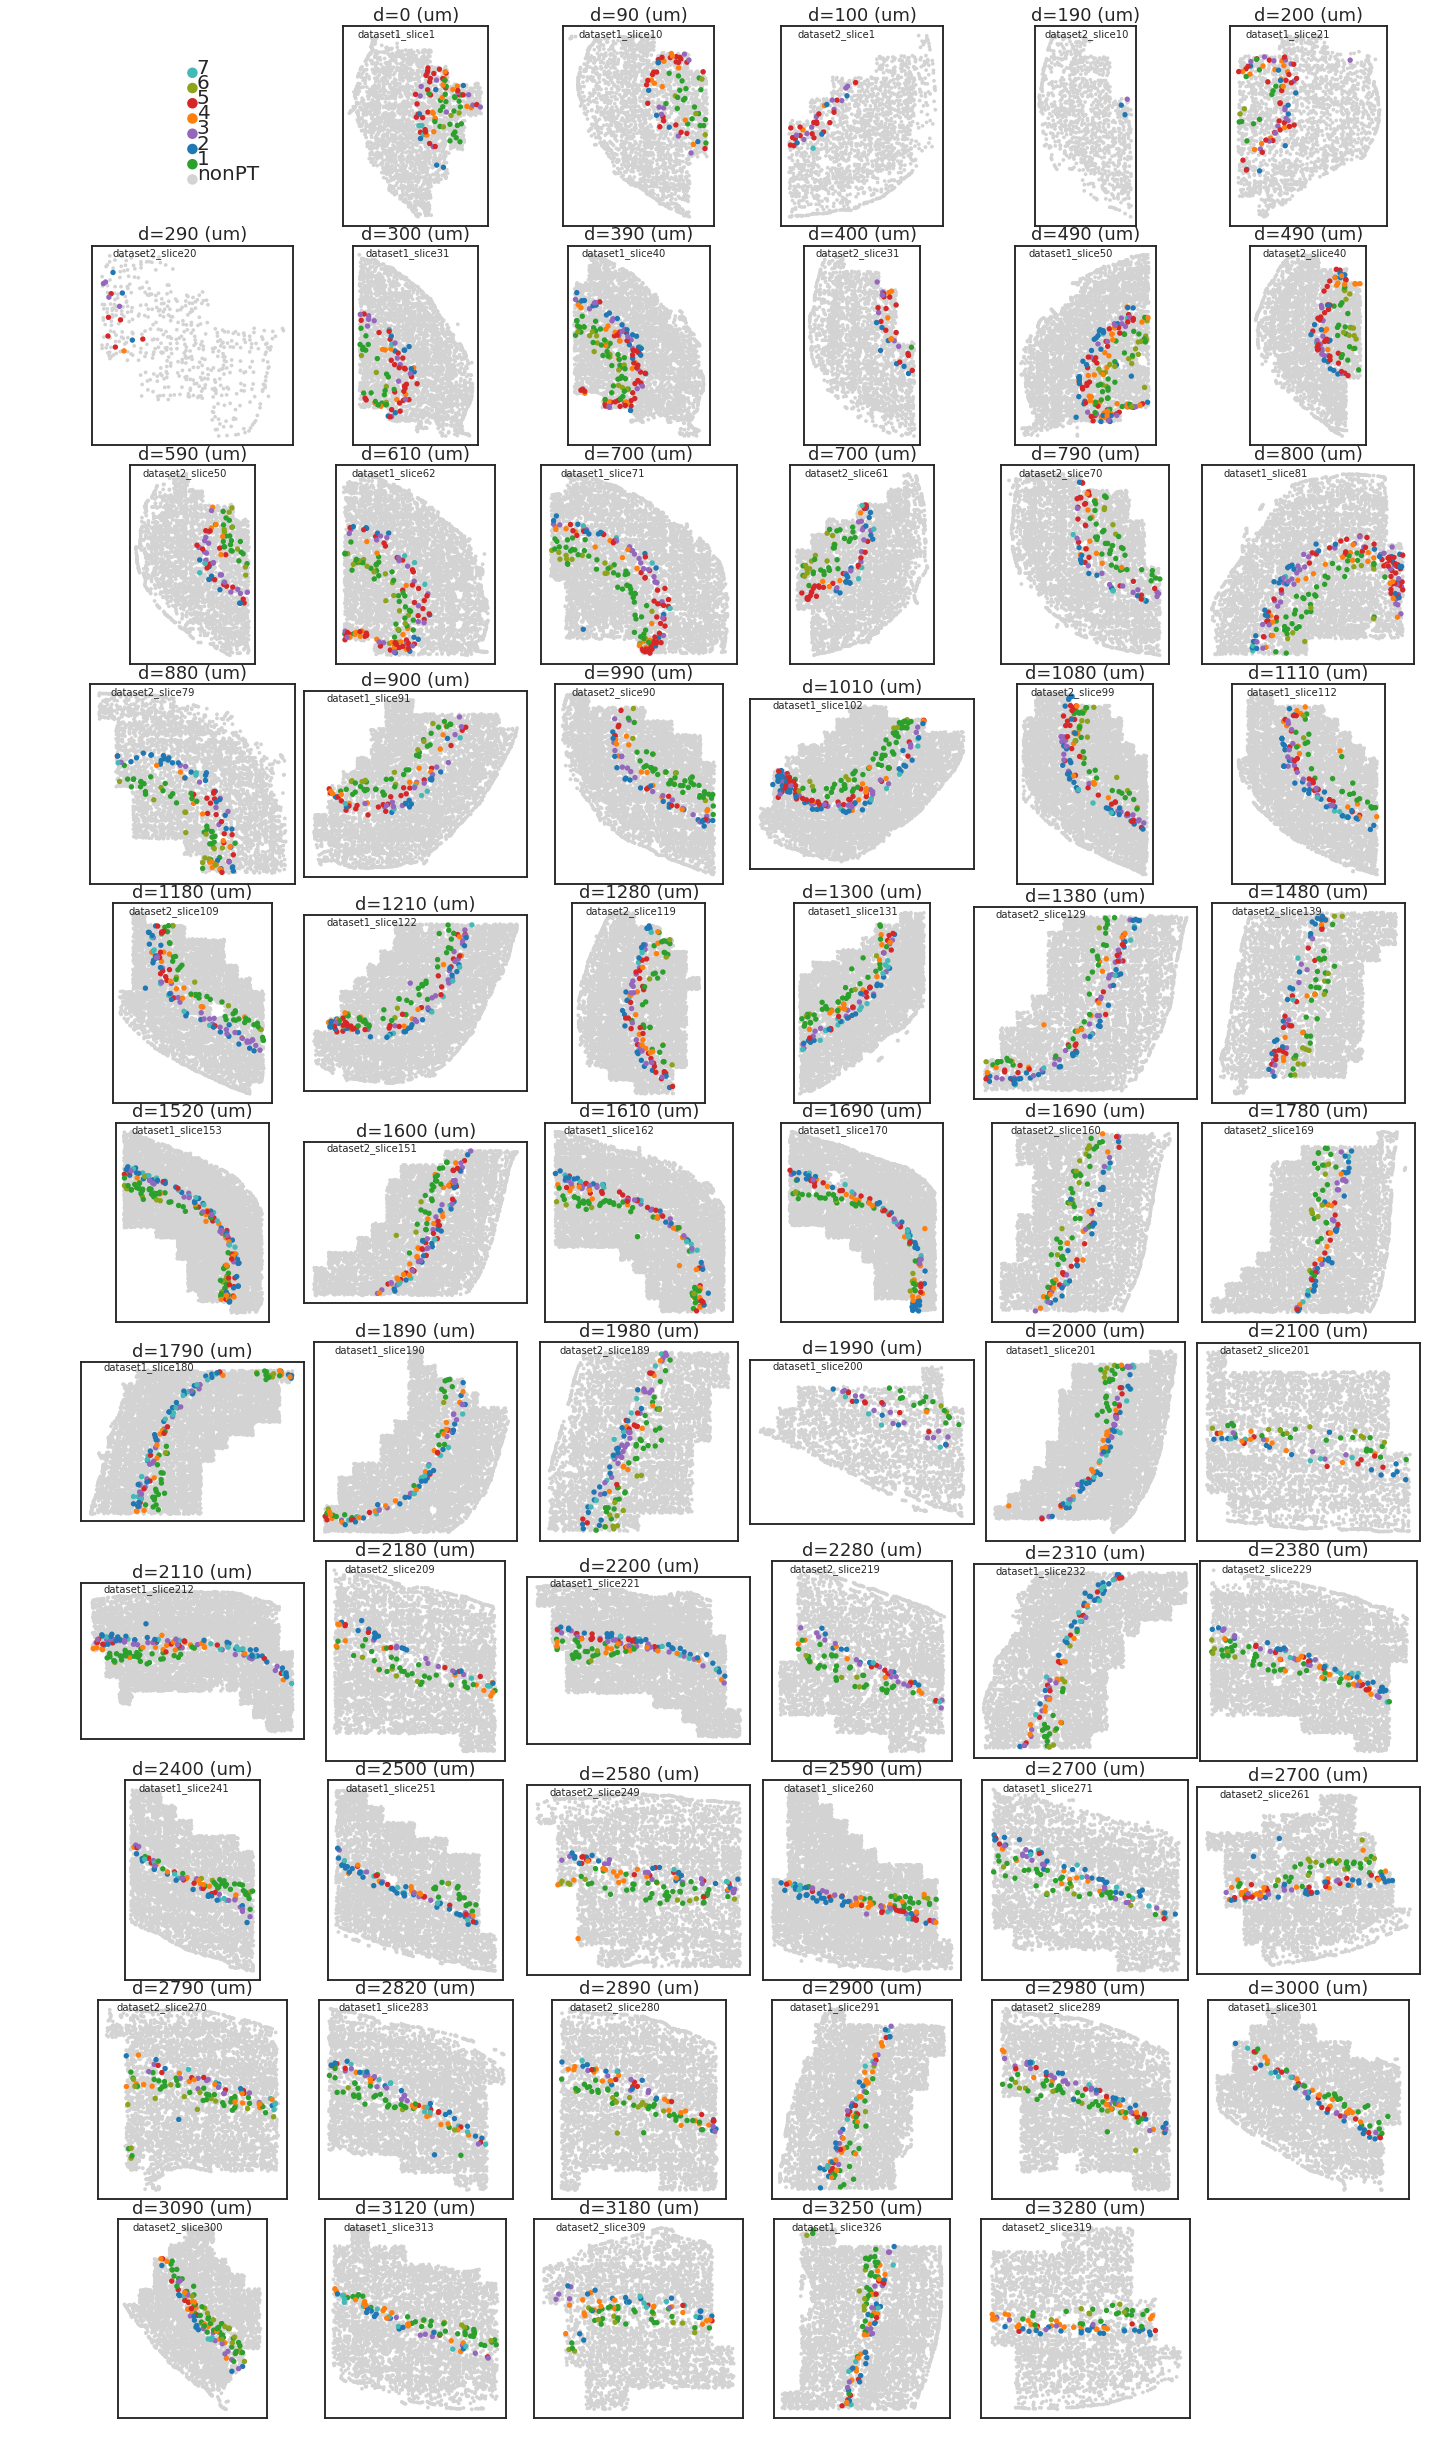

In [18]:
# sample
# n = len(df_plot_sub['sliceID'].unique())

samples = np.sort(df_plot['sampleID'].unique())

n = len(df_plot['sliceID'].unique())+1
nx = 6
ny = int((n+nx-1)/nx) 


tx, ty, tc = 'pos_x (um)', 'pos_y (um)', joint_cluster
fig, axs = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
axs = axs.flatten()

ax = axs[0]
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')



for i, ((_ap_dis, _slice), df_sub) in enumerate(df_plot.groupby(['AP_distance (um)', 'sliceID'])):
    print('.', end='')
    ax = axs[i+1]
    legend_mode = -1
    legend_kws = {}
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]=='nonPT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=-1,
                        s=5,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]!='nonPT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=legend_mode,
                        legend_kws=legend_kws,
                        s=15,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    ax.text(0.1, 0.95, "{}".format(_slice), 
            transform=ax.transAxes,
           )

    ax.set_title("d={} (um)".format(_ap_dis))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
#     if i == 0:
#         ax.set_ylabel()
#     else:

    ax.set_ylabel('')
    ax.grid(False)

for ax in axs[i+2:]:
    ax.axis('off')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_l5pt_7clst'))
plt.show()

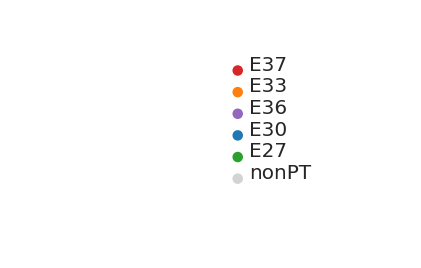

In [13]:
kw_colors=collections.OrderedDict({
                                    "nonPT": 'lightgray', 
                                   'E27': 'C2', 
                                   'E30': "C0",
                                   'E36': 'C4', 
                                   'E33': "C1",
                                   'E37': "C3",
                                  })

scale=0.01
fig, ax = plt.subplots()
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')
snmcseq_utils.savefig(fig, figure_format.format('cluster_legend_merfish'))
plt.show()


................................................................

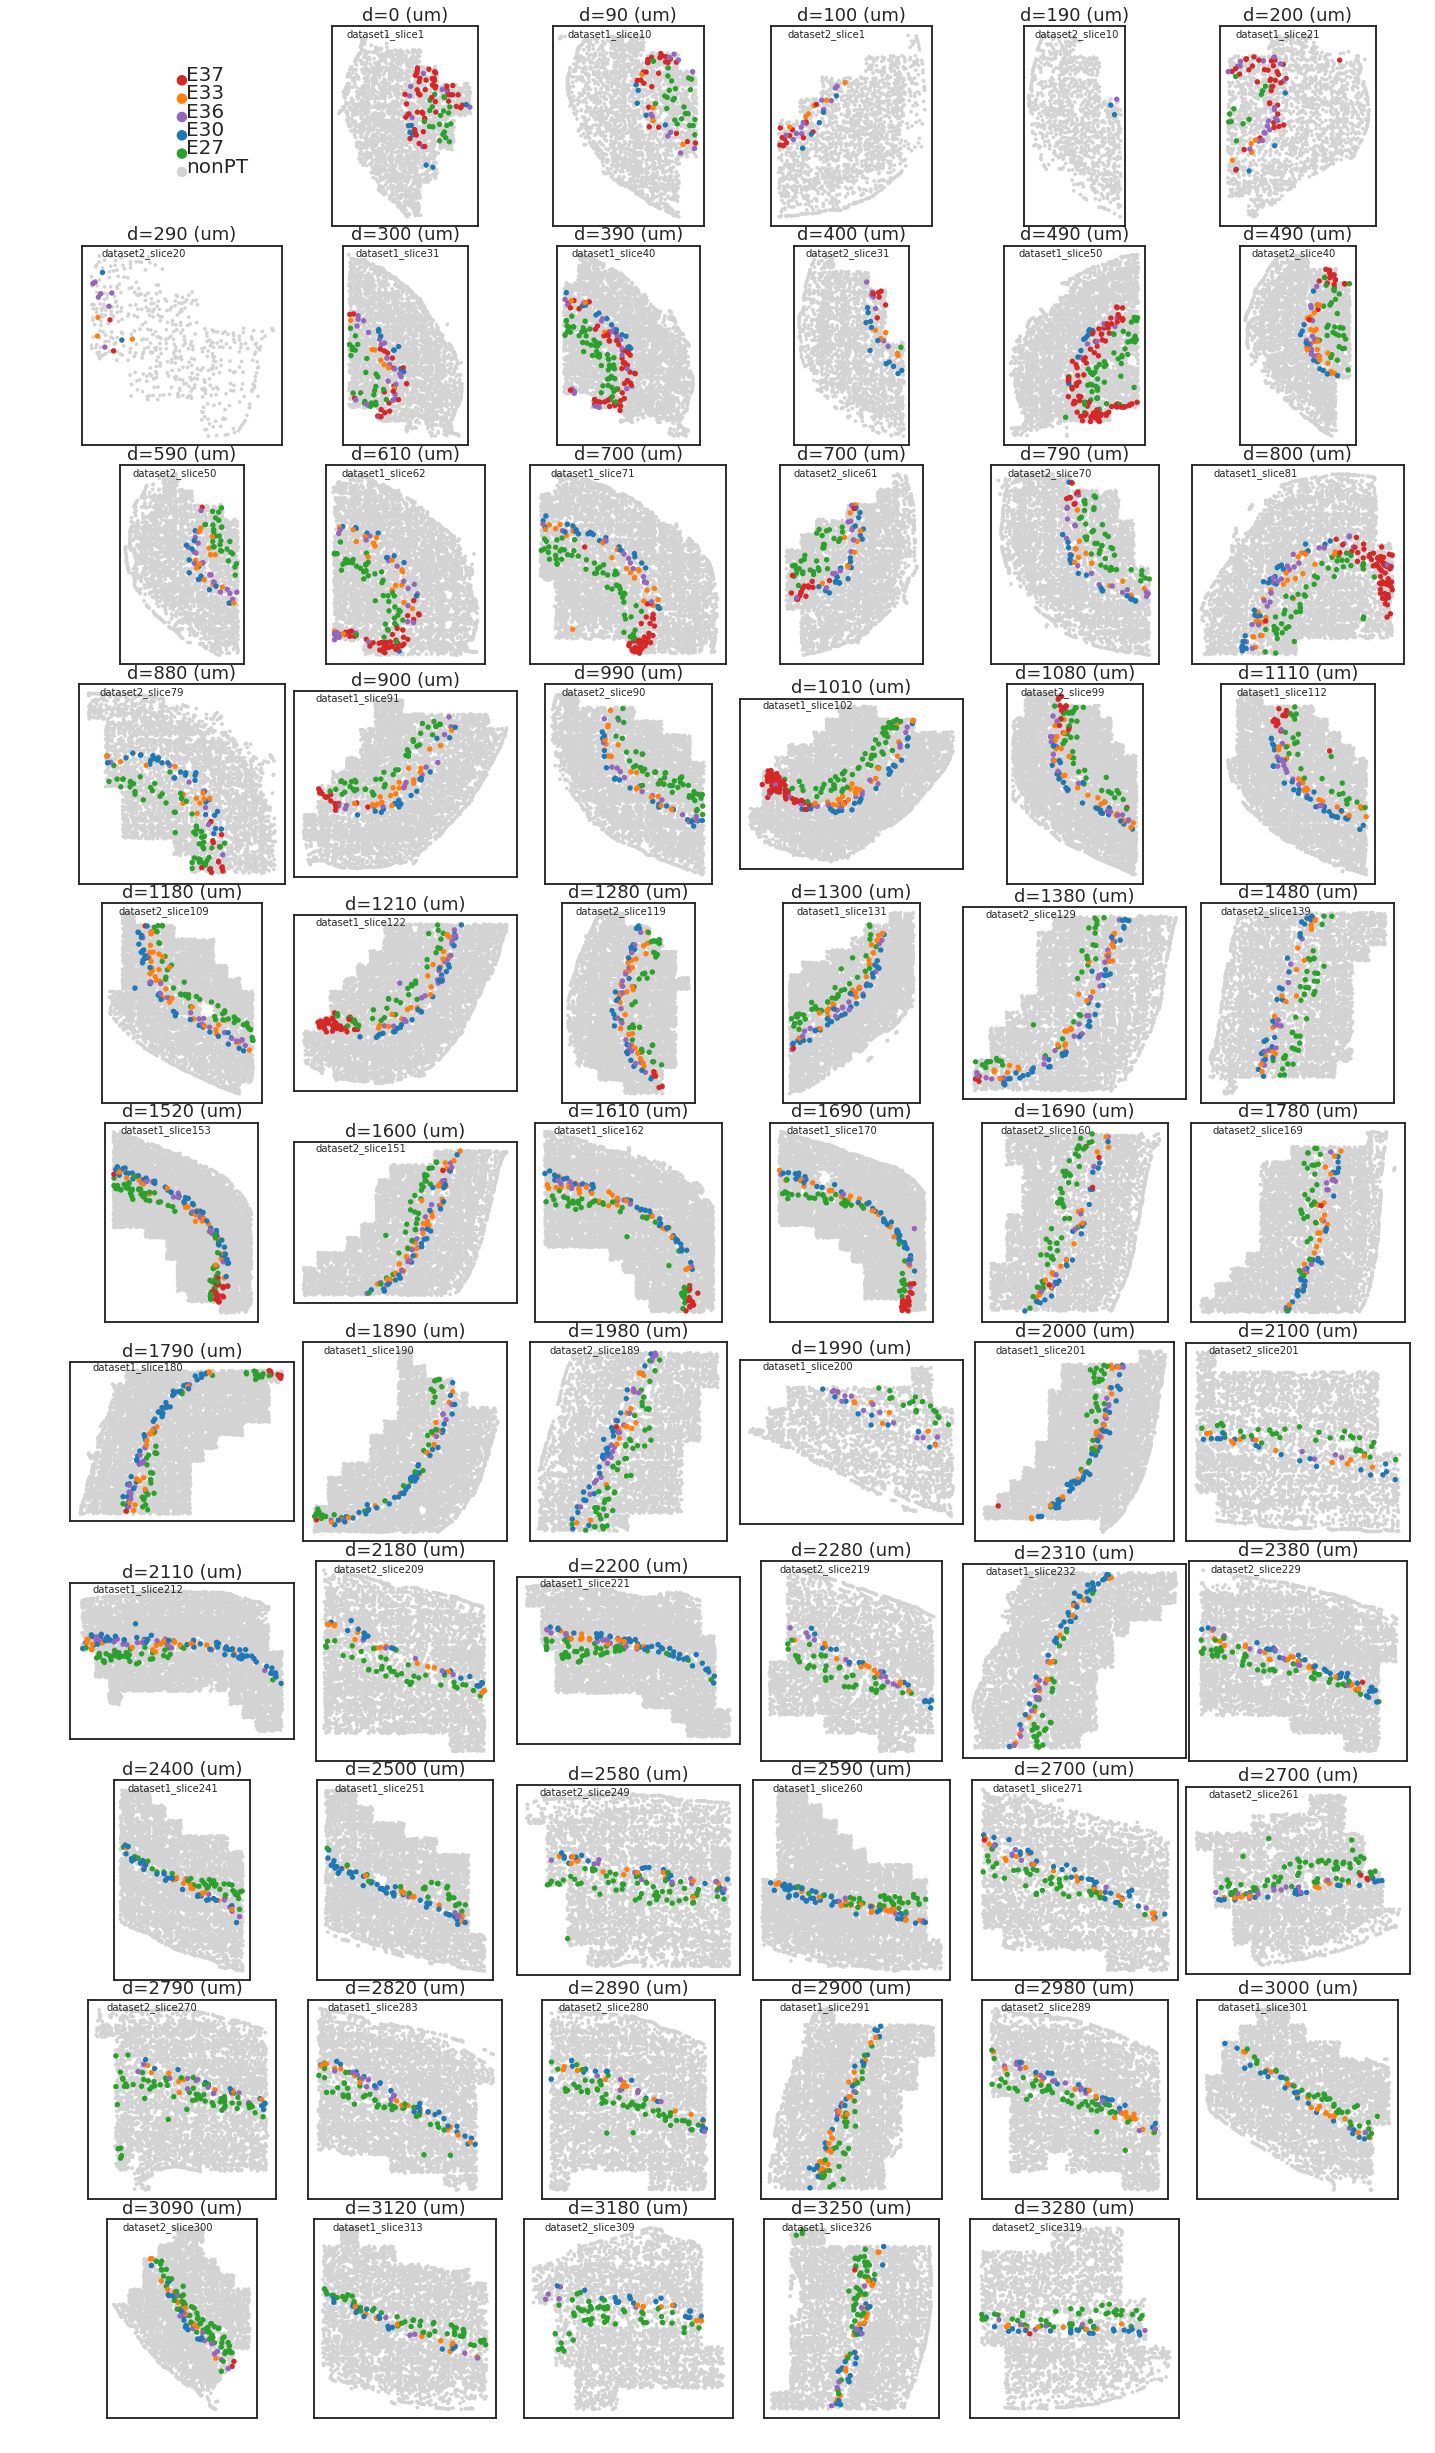

In [14]:
# sample
# n = len(df_plot_sub['sliceID'].unique())

samples = np.sort(df_plot['sampleID'].unique())

n = len(df_plot['sliceID'].unique())+1
nx = 6
ny = int((n+nx-1)/nx) 


tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'final_label'
fig, axs = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
axs = axs.flatten()

ax = axs[0]
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')



for i, ((_ap_dis, _slice), df_sub) in enumerate(df_plot.groupby(['AP_distance (um)', 'sliceID'])):
    print('.', end='')
    ax = axs[i+1]
    legend_mode = -1
    legend_kws = {}
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]=='nonPT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=-1,
                        s=5,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]!='nonPT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=legend_mode,
                        legend_kws=legend_kws,
                        s=15,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    ax.text(0.1, 0.95, "{}".format(_slice), 
            transform=ax.transAxes,
           )

    ax.set_title("d={} (um)".format(_ap_dis))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
#     if i == 0:
#         ax.set_ylabel()
#     else:

    ax.set_ylabel('')
    ax.grid(False)

for ax in axs[i+2:]:
    ax.axis('off')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_l5pt_merfish_cluster'))
plt.show()

................................................................

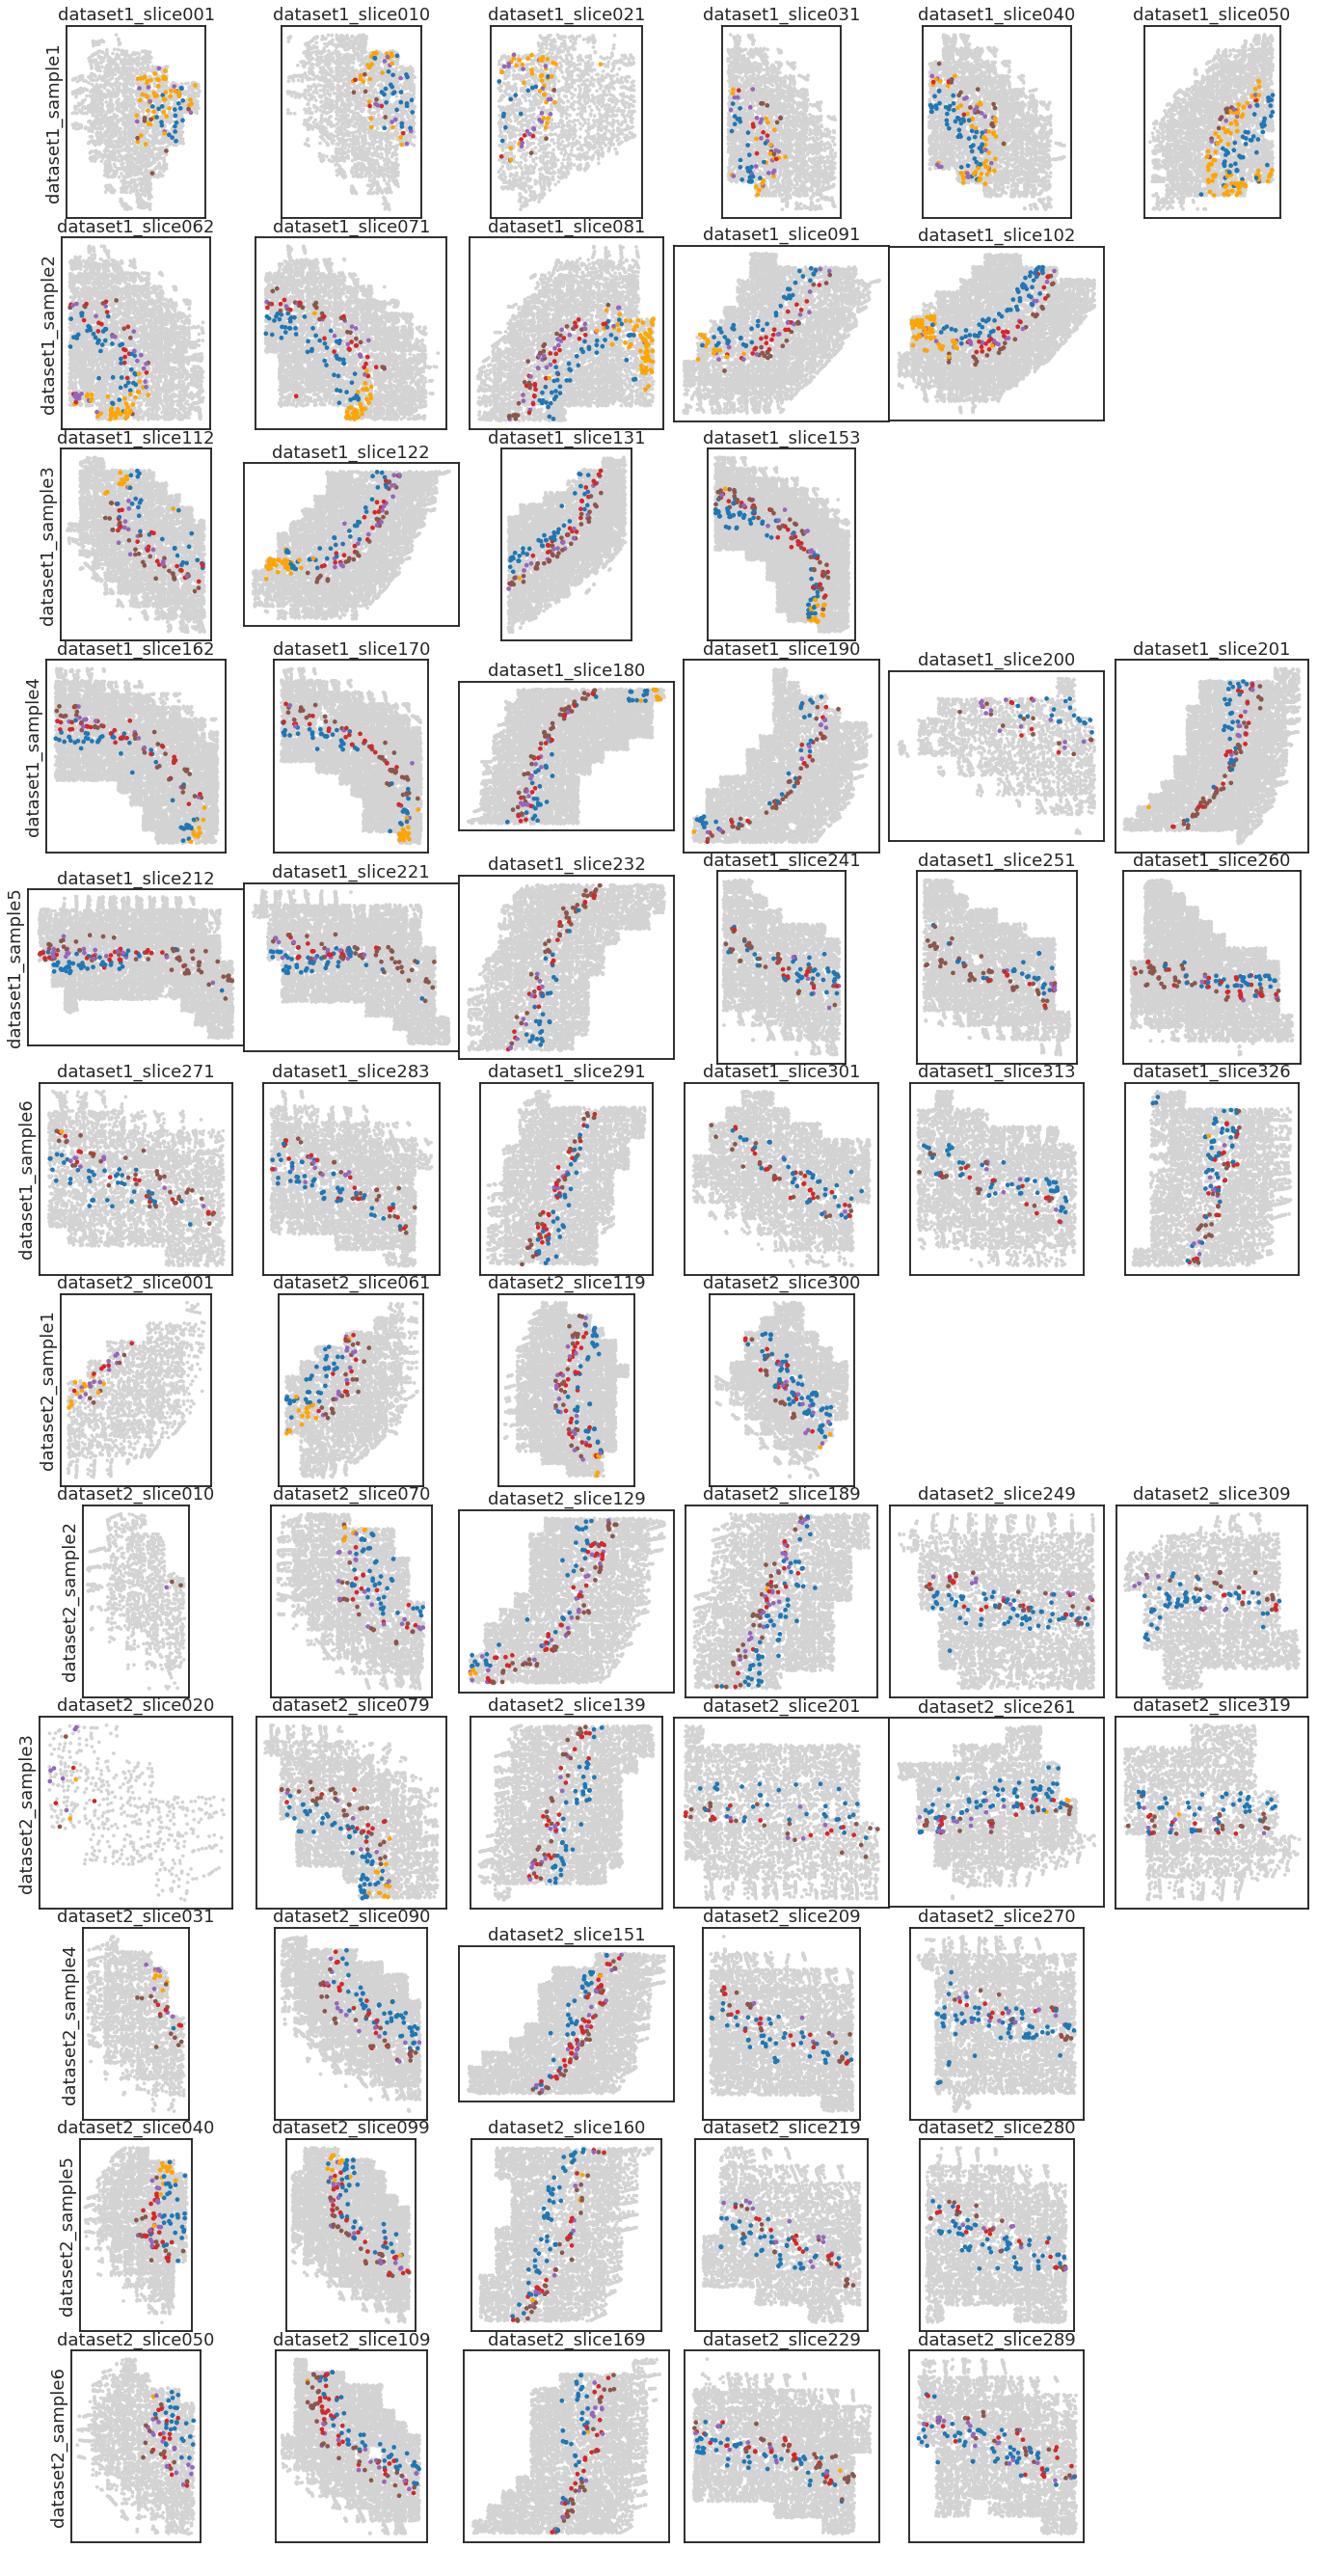

In [60]:
# # sample
# # n = len(df_plot_sub['sliceID'].unique())

# samples = np.sort(df_plot['sampleID'].unique())
# nx = 6
# ny = len(samples) 

# fig, axss = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
# for axs, sample in zip(axss, samples):
#     df_plot_sub = df_plot[df_plot['sampleID']==sample].copy()
#     tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'final_label'
#     df_plot_sub['sliceID'] = df_plot_sub['sliceID'].apply(format_sliceID)
#     for i, (_slice, df_sub) in enumerate(df_plot_sub.groupby('sliceID')):
#         print('.', end='')
#         ax = axs[i]
#         legend_mode = -1
#         legend_kws = {}
#         snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub['final_label']=='nonPT')], ax, 
#                             tx, ty, tc, 
#                             kw_colors=kw_colors,
#                             legend_mode=-1,
#                             s=5,
#                             t_xlim=None,
#                             t_ylim=None,
#                             rasterized=True,
#                            )
#         snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub['final_label']!='nonPT')], ax, 
#                             tx, ty, tc, 
#                             kw_colors=kw_colors,
#                             legend_mode=legend_mode,
#                             legend_kws=legend_kws,
#                             s=10,
#                             t_xlim=None,
#                             t_ylim=None,
#                             rasterized=True,
#                            )

#         ax.set_title(_slice)
#         ax.set_aspect('equal')
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel('')
#         if i == 0:
#             ax.set_ylabel(sample)
#         else:
#             ax.set_ylabel('')
#         ax.grid(False)

#     for ax in axs[min(i+1, nx):]:
#         ax.axis('off')

# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
# snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_l5pt_merfish'))
# plt.show()

### Read in MOp cells 

In [ ]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
meta_mop = pd.read_csv(f, sep='\t')
print(meta_mop.shape)
meta_mop.head()

In [ ]:
f1 = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round1.tsv'
annot1 = pd.read_csv(f1, sep='\t', index_col=0)
annot1.head()

In [ ]:
f2 = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round2.tsv'
annot2 = pd.read_csv(f2, sep='\t', index_col=0)
annot2.head()

In [ ]:
f3 = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round3.tsv'
annot3 = pd.read_csv(f3, sep='\t', index_col=0)
annot3.head()

In [ ]:
f = '/cndd2/fangming/projects/miniatlas/cluster_level/gene_features_10x_cells_v2_round2.tsv'
rna_10x_cells_v2_clst_r2 = pd.read_csv(f, sep='\t', index_col=0)
print(rna_10x_cells_v2_clst_r2.shape)
rna_10x_cells_v2_clst_r2.head()

In [ ]:
f = '/cndd2/fangming/projects/miniatlas/cluster_level/gene_features_10x_cells_v2_round3.tsv'
rna_10x_cells_v2_clst_r3 = pd.read_csv(f, sep='\t', index_col=0)
print(rna_10x_cells_v2_clst_r3.shape)
rna_10x_cells_v2_clst_r3.head()

In [ ]:
# clst_cond = mch_clst_r3.isnull().sum() == len(mch_clst_r3)
# drop_clsts = clst_cond[clst_cond].index.values
# print(drop_clsts)
# mch_clst_r3 = mch_clst_r3.drop(drop_clsts, axis=1)
# print(mch_clst_r3.shape)
# mch_clst_r3.head()

### Correlate 


#### map MERFISH to 56 cell types

In [ ]:
common_genes = np.intersect1d(rna_10x_cells_v2_clst_r3.index.values, data_mfish.index.values)
print(common_genes.shape)

In [ ]:
Y = data_mfish.T
Y['cluster'] = df['final_label']
Y = Y.groupby('cluster').mean().T
print(Y.shape)
Y.head()

In [ ]:
# f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_hvfeatures.gene'
# hvgs = snmcseq_utils.import_single_textcol(f) 
# common_genes = np.intersect1d(common_genes, hvgs)
# print(common_genes.shape)
# common_genes

In [ ]:
X = rna_10x_cells_v2_clst_r3.reindex(common_genes)
# Y = data_mfish.reindex(common_genes)
Y = Y.reindex(common_genes)
X = X.fillna(X.mean(axis=1), axis=0)
Y = Y.fillna(Y.mean(axis=1), axis=0)
print(X.shape, Y.shape)

In [ ]:
corr = snmcseq_utils.spearman_corrcoef(X.T, Y.T)[:len(X.T), len(X.T):]
corr = pd.DataFrame(corr, index=X.columns, columns=Y.columns)
print(corr.shape)
corr.head()

In [ ]:
sns.clustermap(corr, cmap='rocket_r')

### MERFISH vs SCF correspondance 

2 choices:
- map MERFISH and RS2 data to SCF data
- full integration of MERFISH and RS2 data to SCF data
- PATCH-seq data?

benefits:
- knowing spatial info 
- knowing connectivity info

In [ ]:
clsts_manual_order = collections.OrderedDict({
      '4-1-1': 'L2/3 IT ',
      '4-1-2': 'L2/3 IT ',
      '4-2-1': 'L2/3 IT ',
      '4-2-2': 'L2/3 IT ',
      '4-2-3': 'L2/3 IT ',
      '1-1-1': 'L5 IT Rspo1_1',
      '1-2-1': 'L5 IT Rspo2_1',
      '1-2-2': 'L5 IT Tcap_1',
      '3-1-2': 'L5 IT S100b',
      '3-2-1': 'L5 IT S100b',
      '3-2-2': 'L5 IT S100b',
      '3-1-1': 'L6 IT_2',
      '3-3-1': 'L6 IT Car3',
    
      '9-1-1': 'L5 ET_1',
      '9-2-1': 'L5 ET_2',
      '9-2-2': 'L5 ET_3',
    
      '2-1-1': 'L6 CT Cpa6',
      '2-1-2': 'L6 CT Cpa6',
      '2-2-1': 'L6 CT Cpa6',
      '2-2-2': 'L6 CT Cpa6',
      '2-2-3': 'L6 CT Gpr139',
      '2-2-4': 'L6 CT Cpa6',
      '2-3-1': 'L6 CT Nxph2 Pou3f2',
      '2-3-2': 'L6 CT Nxph2 Pou3f2',
      '2-3-3': 'L6 CT Nxph2 Kit',
    
      '8-1-1': 'L6b Shisa6_1',
      '8-1-2': 'L6b Shisa6_2_2',
      '8-2-1': 'L6b Ror1',
      '8-3-1': 'L6b Kcnip1_2',
      '8-3-2': 'L6b Kcnip1_2',
    
      '7-1-1': 'L6 NP Trh_1',
      '7-1-2': 'L5 NP Trh',
      '7-2-1': 'L5 NP Slc17a8',
      '7-2-2': 'L5 NP Slc17a8',
    
      '5-4-1': 'Pvalb Gabrg1',
      '5-1-1': 'Pvalb Reln',
      '5-1-2': 'Pvalb Calb1_1',
      '5-5-1': 'Pvalb Vipr2',
    
      '5-2-1': 'Sst Myh8_2',
      '5-2-2': 'Sst Crhr2_1',
      '5-2-3': 'Sst Crhr2_2',
      '5-3-1': 'Sst Calb2',
      '5-3-2': 'Sst Hspe_3',
      '10-1-1': 'Sst Chodl',
    
      '6-1-1': 'Vip Chat',
      '6-1-2': 'Vip Crispld2',
      '6-3-1': 'Vip Gpc3',
      '6-3-2': 'Vip Htr1f_1',
      '6-5-3': 'Sncg Npy2r',
      '6-3-3': 'Vip Igfbp6',
      '6-5-2': 'Vip Serpinf1_2',
      '6-5-1': 'Sncg Col14a1',
    
      '6-6-1': 'Lamp5 Lhx6',
      '6-2-1': 'Lamp5 Slc35d3',
      '6-4-1': 'Lamp5 Pdlim5',
      '6-4-2': 'Lamp5 Pax6',
    
})

clsts_uniq = np.array(list(clsts_manual_order.keys()))

In [ ]:
# assign to the best cluster
df_match = corr.idxmax(axis=0).to_frame('best_match').reset_index()
df_match = pd.merge(df_match, pd.Series(clsts_uniq).to_frame('best_match').reset_index(), on='best_match')
df_match_sub = df_match.loc[~df_match['cluster'].str.contains(r'^[E,I][0-9]')].copy() 
df_match_sub['index'] = 1000
df_match.update(df_match_sub)
df_match = df_match.sort_values('index')

# df_match_sub.loc[df_match_sub['cluster'].str.contains(r'^[E,I]'), 'index'] = 1000
# print(df_match['cluster'].str.contains(r'^[E,I]').unique())
print(df_match.shape)
print(df_match.to_string())

# df_info = df.copy()
# df_info['best_match'] = corr.idxmax(axis=1)
# df_info['best_match_annot'] = df_info['best_match'].apply(lambda x: annot3.loc[x, 'annotation_curated'])
# print(df_info.shape)
# df_info.head()

In [ ]:
mfish_clsts_order = df_match['cluster']

In [ ]:

fig, ax = plt.subplots(figsize=(12,10))

cbar_kws = {'label': 'Spearman correlation', 
            }
cbar_ax = fig.add_axes([0.95, 0.2, 0.03, 0.3])

sns.heatmap(corr.loc[clsts_uniq, mfish_clsts_order], 
            cmap='rocket_r', 
            xticklabels=True,
#             yticklabels=True,
#             xticklabels=False,
            yticklabels=["{}".format(annot3.loc[x, 'annotation_curated']) for x in clsts_uniq],
            cbar_ax=cbar_ax,
            cbar_kws=cbar_kws,
            ax=ax,
            vmin=0.2,
            rasterized=True,
           )
ax.set_xlabel('MERFISH')
ax.set_ylabel('SCF (RNA, mC, ATAC)')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
snmcseq_utils.savefig(fig, figure_format.format('01_merfish_cluster_correlations'))
plt.show()

### Next step L5 PT
- 5 merfish types; 6 epi-retro-seq types; 4 RNA consensus types; 3 SCF types 